In [166]:
from collections.abc import Callable
from typing import Any
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric import nn as gnn

from torch.nn import functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [2]:
# define and undirected graph: 4 edges for 2 connected nodes.
edge_index = torch.tensor([
    [0, 1, 1, 2],
    [1, 0, 2, 1]],
    dtype=torch.long
)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# Graphs in torch_geometric are described by instances of torch_geometric.data.Data
data = Data(x=x, edge_index=edge_index)

data.validate(raise_on_error=True)
print(data)
print(data.keys())
for key, item in data:
    print(f'key {key} in data with item {item}.')

print(data.num_nodes, data.num_edges, data.num_node_features)

Data(x=[3, 1], edge_index=[2, 4])
['x', 'edge_index']
key x in data with item tensor([[-1.],
        [ 0.],
        [ 1.]]).
key edge_index in data with item tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]]).
3 4 1


In [68]:
class ConfusionMatrix:
    def __init__(self):
        self.confusion_matrix = np.empty(0)
        self._y_hat = []
        self._y_true = []

    def update(self, y_hat, y_true):
        self._y_hat.append(np.asarray(y_hat))
        self._y_true.append(np.asarray(y_true))

    def compute(self):
        y_hat = np.concat(self._y_hat)
        y_true = np.concat(self._y_true)
        pred = np.argmax(y_hat, axis=1)
        confusion_matrix_ = confusion_matrix(y_true, pred)
        return confusion_matrix_

    def reset(self):
        self._y_true = []
        self._y_hat = []

In [ ]:
def test_confusion_matrix():
    matrix = ConfusionMatrix()
    matrix.update(torch.tensor([[.1, .9], [.9, .1]]), torch.tensor([0, 1]))
    matrix.update(torch.tensor(
        [
            [.9, .1],
            [.9, .1],
            [.1, .9],
        ]),
        torch.tensor([0, 1, 1])
        )

    result = matrix.compute()
    assert result[0, 0] == 1
    assert result[1, 1] == 1

test_confusion_matrix()

## Cora Citations

Training on Cora is a node classification task. We have a single graph; our goal is to classify each node as the subject field of the paper it represents. The edges in Cora are citations.

In [3]:
from torch_geometric.datasets import Planetoid
citation_data = Planetoid(root='/workspace/local_data/Cora', name='Cora')
loader = DataLoader(citation_data, batch_size=32)

# In this dataset, we have a single graph (the iteration happens once--one batch.)
# it has 2708 nodes with 1433 features (one hot publication id?) and 10566 undirected
# edges, which are citaions for one articule to another.
# The y values are a class corresponding to the node's class.

for batch in loader:
    assert batch.is_undirected() == True
    print(citation_data.num_classes)
    print(batch)


7
DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [4]:
import numpy as np
classes = citation_graph.y.detach().numpy().astype(np.int64)

def one_hot(x, number_of_classes):
    return np.eye(number_of_classes)[x]

one_hot(classes, 7).sum(axis=0) / 2708
F.one_hot(citation_graph.y[citation_data.train_mask]).sum(axis=0), F.one_hot(citation_graph.y[citation_data.test_mask]).sum(axis=0)

NameError: name 'citation_graph' is not defined

In [ ]:

class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data: Data, *_,):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x =  F.log_softmax(x, dim=1)
        return x

citation_graph = citation_data[0]

model = GCN(citation_data)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=5e-4)

def train_citations(model, n_epochs):
    print("Training network on citations.")
    best_loss = torch.inf
    n_no_improvement = 0
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_hat = model(citation_graph)
        loss = F.nll_loss(y_hat[citation_graph.train_mask], citation_graph.y[citation_graph.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_hat_val = model(citation_graph)
            val_loss = F.nll_loss(y_hat_val[citation_graph.test_mask], citation_graph.y[citation_graph.test_mask])
            # val_loss = loss
            pred = y_hat_val.argmax(dim=1)
            correct = (pred[citation_graph.test_mask] == citation_graph.y[citation_graph.test_mask]).sum()
            accuracy = int(correct) / int(citation_graph.test_mask.sum())

        if epoch % 25 == 0:
            print(f"Loss: {val_loss.item():.5f}, Accuracy: {accuracy:.3f}  (epoch {epoch})")
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_accuracy = accuracy
            n_no_improvement = 0
        else:
            n_no_improvement += 1
            if n_no_improvement > 50:
                break

    print(f"\nLoss of best model: {best_loss:.5f}, accuracy {accuracy:.3f} (training loss: {loss.item()})")

train_citations(model, n_epochs=500)


## Enzymes

In [ ]:
# NOTE: dataset expects this capitalization of the path and names.
enzyme_data = TUDataset(root='local_data/ENZYMES', name='ENZYMES')
print(enzyme_data, 'num features: ', enzyme_data.num_node_features, 'num classes: ', enzyme_data.num_classes)

# The data includes 600 graphs.
# each graph has a a single taget variable, which is one of the six classes; y=[1]
# the graphs themselves have variables numbers of nodes and edges.
print(enzyme_data[0])
print(enzyme_data[1])

ENZYMES(600) num features:  3 num classes:  6
Data(edge_index=[2, 168], x=[37, 3], y=[1])
Data(edge_index=[2, 102], x=[23, 3], y=[1])


Type:        TUDataset
String form: ENZYMES(600)
Length:      600
File:        ~/.local/lib/python3.11/site-packages/torch_geometric/datasets/tu_dataset.py
Docstring:  
A variety of graph kernel benchmark datasets, *.e.g.*,
:obj:`"IMDB-BINARY"`, :obj:`"REDDIT-BINARY"` or :obj:`"PROTEINS"`,
collected from the `TU Dortmund University
<https://chrsmrrs.github.io/datasets>`_.
In addition, this dataset wrapper provides `cleaned dataset versions
<https://github.com/nd7141/graph_datasets>`_ as motivated by the
`"Understanding Isomorphism Bias in Graph Data Sets"
<https://arxiv.org/abs/1910.12091>`_ paper, containing only non-isomorphic
graphs.

.. note::
    Some datasets may not come with any node labels.
    You can then either make use of the argument :obj:`use_node_attr`
    to load additional continuous node attributes (if present) or provide
    synthetic node features using transforms such as
    :class:`torch_geometric.transforms.Constant` or
    :class:`torch_geometric.transforms.One

In [229]:
from collections.abc import Iterable

from philosofool.torch.callbacks import VerboseTrainingCallback
from philosofool.torch.nn_loop import TrainingLoop

class DefaultGraphAdapter:
    def __init__(self, features: Iterable[str], target='y'):
        self.features = features
        self.target = target

    def get_inputs(self, data_batch) -> list:
        inputs = [getattr(data_batch, feature) for feature in self.features]
        return inputs

    def get_target(self, data_batch) -> torch.Tensor:
        return getattr(data_batch, self.target)

    def get_train_mask(self, data_batch):
        return getattr(data_batch, 'train_mask', None)

    def get_val_mask(self, data_batch):
        return getattr(data_batch, 'test_mask', None)


class GraphTrainingLoop(TrainingLoop):
    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer, loss: 'Loss', adapter: DefaultGraphAdapter, name='graph_training_loop'):
        super().__init__(model, optimizer, loss, adapter, name)
        if self.adapter is None:
            self.adapter = DefaultGraphAdapter()


    def process_batches(self, loader: DataLoader, with_grad: bool = True, eval: bool | None = None):
        self._set_train_state(with_grad, eval)

        for batch, data in enumerate(loader):
            X = self.adapter.get_inputs(data)
            y = self.adapter.get_target(data)
            if with_grad:
                # !! return signature breaks contract of parent class!
                # we thinking throught how to get this work without a child
                # class. This will be a pain point.
                loss, pred_masked, y_masked = self._compute_loss_pred_optimize(X, y)
            else:
                loss, pred_masked, y_masked = self._compute_loss_pred(X, y)
            yield batch, loss.item(), pred_masked.detach(), y_masked

    def _compute_loss_pred_optimize(self, X, y):
        mask = self.adapter.get_train_mask(X)
        pred = self.model(*X)
        if mask is None:
            # in this case, treat pred_masked is pred
            pred_masked = pred
            y_masked = y
        else:
            pred_masked = pred[mask]
            y_masked = y[mask]
        loss = self.loss(pred_masked, y_masked)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss, pred_masked, y_masked

    def _compute_loss_pred(self, X, y):
        mask = self.adapter.get_train_mask(X)
        with torch.no_grad():
            pred = self.model(*X)
            if mask is None:
                # in this case, treat pred_masked is pred
                pred_masked = pred
                y_masked = y
            else:
                pred_masked = pred[mask]
                y_masked = y[mask]
            loss = self.loss(pred_masked, y_masked)
        return loss, pred_masked, y_masked


    def test(self, loader: DataLoader):
        self.model.eval()
        test_loss, correct = 0., 0.
        with torch.no_grad():
            for batch, data in enumerate(loader):
                pred = self.model(data.x, data.edge_index, data.batch)
                test_loss += self.loss(pred, data.y).item()
                correct += (pred.argmax(1) == data.y).sum().item()
        test_loss /= len(loader)
        correct /= len(loader.dataset)
        return correct, test_loss


In [ ]:
from torch import dropout


class GraphPredGCN(torch.nn.Module):
    def __init__(self, node_features:int, num_classes: int, hidden_channels: int, n_convolutions: int, dropout: float):
        super().__init__()

        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.pool1 = gnn.pool.SAGPooling(hidden_channels, ratio=.5)
        self.pool2 = gnn.pool.SAGPooling(hidden_channels, ratio=.5)
        self.linear = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x, edge_index, _, batch, *__ = self.pool1(x, edge_index, batch=batch)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        if self.dropout:
            x = nn.Dropout(self.dropout)
        x, edge_index, _, batch, *__ = self.pool2(x, edge_index, batch=batch)

        if self.dropout:
            x = nn.Dropout(self.dropout)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        if self.dropout:
            x = nn.Dropout(self.dropout)

        x = global_mean_pool(x, batch)
        x = self.linear(x)
        return x

In [263]:
enzyme_data = enzyme_data.shuffle()
train_size = 400
train_enzymes = enzyme_data[:train_size]
test_enzymes = enzyme_data[train_size:]

def graph_dataset_summary(dataset):
    n = len(dataset)
    n_classes = dataset.num_classes
    n_features = dataset.num_node_features
    label_dis = F.one_hot(dataset.y).sum(dim=0) if hasattr(dataset, 'y') else None
    report = f"Dataset with {n} nodes, {n_classes} classes and {n_features} node features."
    if label_dis is not None:
        label_dis = ', '.join([f'{x:.3f}' for x in label_dis / n])
        report += f"\nDistribution of classes is {label_dis}."
    print(report)

graph_dataset_summary(train_enzymes)

Dataset with 400 nodes, 6 classes and 3 node features.
Distribution of classes is 0.183, 0.172, 0.160, 0.172, 0.147, 0.165.


In [264]:
import seaborn as sns

def plot_history(history: dict, plots: list):
    fig, ax = plt.subplots(1, len(plots))
    fig.set_size_inches(len(plots) * 4, 4)
    plots = [(idx, key + suffix) for suffix in ['', '_val'] for idx, key in enumerate(plots)]
    fig.tight_layout()
    for idx, key in plots:
        value = history[key]
        ax[idx].plot(range(len(value)), value, label=key)

def heatmaps(history):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    fig.tight_layout()
    sns.heatmap(history['confusionmatrix'][-1], ax=ax[0])
    sns.heatmap(history['confusionmatrix_val'][-1], ax=ax[1])


In [279]:
from matplotlib.pyplot import hist
from philosofool.torch.callbacks import MetricsCallback
from philosofool.torch.metrics import Accuracy

try:
    histories
except NameError:
    histories = []

train_loader = DataLoader(train_enzymes, batch_size=32)
test_loader = DataLoader(test_enzymes, batch_size=32)

model = GraphPredGCN(train_enzymes.num_node_features, train_enzymes.num_classes, 32, None, dropout=.2)

optimizer = torch.optim.Adam(model.parameters(), lr=.002)
# optimizer = torch.optim.SGD(model.parameters(), momentum=.9, lr=.01)
confusion_callback = ConfusionMatrix()
loop = GraphTrainingLoop(model, optimizer, torch.nn.CrossEntropyLoss(), adapter=DefaultGraphAdapter(['x', 'edge_index', 'batch']))
loop.fit(train_loader, test_loader, epochs=500, callbacks=[
    MetricsCallback([Accuracy('multiclass'), confusion_callback])])
histories.append(loop.history)
# loop.history


array([[ 4,  1,  5,  7,  6,  4],
       [ 5,  8,  5,  3,  3,  7],
       [ 5,  6, 16,  0,  6,  3],
       [ 4,  9,  5,  7,  5,  1],
       [10,  2,  5,  7, 13,  4],
       [ 2,  4,  1,  5,  5, 17]])

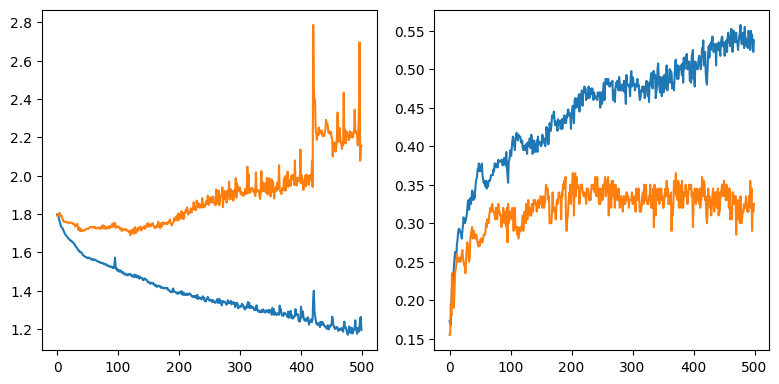

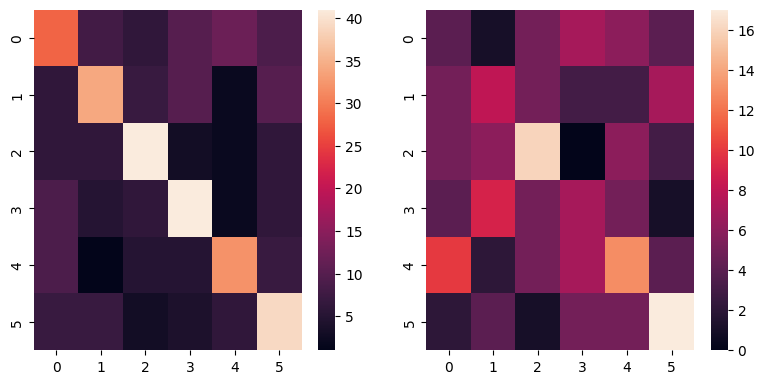

In [280]:
plot_history(loop.history, ['loss', 'accuracy'])
heatmaps(loop.history)

loop.history['confusionmatrix_val'][-1]

In [26]:
one_batch = next(iter(train_loader))
one_batch.to('cpu')

DataBatch(edge_index=[2, 4146], x=[1173, 3], y=[32], batch=[1173], ptr=[33])